# Distributed Compressed Sensing (Multi-Machine Version)

This notebook implements a **multi-machine distributed compressed sensing** experiment deployed on heterogeneous devices, including **Raspberry Pi nodes** and commodity machines.  
Its main purpose is to evaluate the **wall-clock runtime impact of communication quantization** in a resource-constrained distributed environment.

---

## Problem Formulation

We consider the centralized objective:

$$
\min_{x \in \mathbb{R}^d}\;
\frac{1}{16}\sum_{i=1}^{16}\left(C_i \Psi x - y_i\right)^2
+ \lambda \|x\|_1 .
$$

Here, $C_i$ denotes the local measurement matrix of node $i$ (randomly selected rows of the identity matrix),  
$\Psi$ is the discrete cosine transform (DCT) basis, and $y_i$ is the corresponding local observation vector.  
The centralized optimal solution is denoted by $x^*$.

---

## Difference from the Single-Machine Multi-Process Notebook

A single-machine multi-process version is provided in the same directory.  
While that notebook focuses on algorithm behavior and visualization, this notebook targets a **real multi-device distributed setting** and emphasizes **system-level performance** under limited hardware and network capabilities.

In particular, we prioritize **wall-clock timing** and keep the runtime manageable by omitting extensive visualization and detailed convergence diagnostics.

---

## Main Objective

The primary goal is to compare the execution time of distributed optimization under:

- **Unquantized communication** (`float64`), and
- **Quantized communication** (`float64 → int16`).

Because the experiment includes **resource-constrained Raspberry Pi nodes**, reducing communication payload may significantly reduce the overall runtime.

Importantly, the reported runtime covers the **full algorithm execution**: each timing measurement includes both communication and the **quantization/dequantization overhead** inside the normal iteration loop (i.e., not measured in isolation).

---

## Experimental Setup

We run a synchronous distributed algorithm (RAugDGM) on **16 workers** in total:

- **8 Raspberry Pi nodes** (1 process each),
- **1 desktop machine** running **4 processes**, and
- **1 laptop** running **4 processes**.

The system is **synchronous**, so each iteration requires all workers to reach the synchronization point.  
Therefore, the overall runtime is dominated by the **slowest workers**, which in our setting are typically the Raspberry Pi nodes.

---

## Experimental Design

To keep the total runtime manageable while still being comparable across settings:

- We run the algorithm for **500 iterations** per setting.
- For each round, we execute:
  - 500 iterations with **unquantized** communication, and
  - 500 iterations with **quantized** communication.
- We record the **total wall-clock runtime per round** (measured at the coordinator/master side).
- We repeat the above for **20 rounds** to capture variability and produce a stable timing comparison.
- Finally, we plot the per-round runtime results to compare quantized vs. unquantized communication.

This notebook therefore focuses on **runtime comparison between communication schemes**, rather than detailed convergence analysis or reconstruction quality evaluation.

In [1]:
import numpy as np
import numpy.typing as npt

from scipy.fftpack import dct

# Sensors
import networkx as nx

n_grid = 4
grid = nx.grid_2d_graph(n_grid, n_grid)
L: npt.NDArray[np.float64] = np.asarray(nx.laplacian_matrix(grid).todense())
W = np.eye(16) - L * 0.1

from topolink import Graph, bootstrap

graph = Graph.from_mixing_matrix(W, transport="tcp")
n_sens = graph.number_of_nodes
sens_names = [f"{i + 1}" for i in range(n_sens)]

# Original signal
n = 4096
t = np.linspace(0, 1, n)
x = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t)

# Signal sampling
np.random.seed(3)
p_total = 128
p_sens = p_total // n_sens
perm = {i: np.round(np.random.rand(p_sens) * n).astype(int) for i in sens_names}
y = {i: x[perm[i]] for i in sens_names}

# Sensing matrix and regularization parameter
Psi = dct(np.eye(n), norm="ortho").astype(np.float64, copy=False)
Theta = {i: Psi[perm[i], :] for i in sens_names}
lam = 0.01

# Time record
time_record: dict[str, list[float]] = {"quantized": [], "unquantized": []}

## Timing Evaluation of RAugDGM

This notebook focuses on evaluating the **runtime performance** of the distributed algorithm **RAugDGM** for a distributed LASSO problem arising from compressed sensing, rather than benchmarking multiple optimization algorithms.

The experiment is conducted on a $4 \times 4$ grid network.  
The gossip matrix is defined as

$$
W = I - 0.1 L,
$$

where $L$ is the Laplacian matrix of the communication graph.

We compare the execution time of RAugDGM using unquantized communication (float64) and quantized communication (float64 $\rightarrow$ int16).

In [4]:
import ray

ray.init(address="auto")


@ray.remote(num_cpus=1)
def lasso(
    node_id: str,
    g_name: str,
    theta_i: npt.NDArray[np.float64],
    y_i: npt.NDArray[np.float64],
    dim_i: int,
    lam_i: float,
    max_iter: int,
    quantize: bool,
) -> float:
    from numpy import zeros

    s_hat_i = zeros((max_iter, dim_i), dtype=np.float64)

    # Define the loss function
    from jax import Array
    from jax.numpy.linalg import norm

    def f(var: npt.NDArray[np.float64]) -> Array:
        return norm(theta_i @ var - y_i) ** 2

    # Define the regularizer
    from dco import L1

    g = L1(lam_i)

    # Define the node handle
    from topolink import NodeHandle, Quantize

    transform = Quantize(dtype="int16") if quantize else None

    nh = NodeHandle(node_id, g_name, transform=transform, transport="tcp")

    # Define the optimizer and run iterations
    from dco import RAugDGM

    optimizer = RAugDGM(f, nh, 1.358, g)

    import time

    begin_time = time.time()

    optimizer.init(s_hat_i[0])

    for k in range(max_iter - 1):
        s_hat_i[k + 1] = optimizer.step(s_hat_i[k])

    end_time = time.time()

    return end_time - begin_time


NUM_RUNS = 20
MAX_ITER = 100

try:
    for run in range(NUM_RUNS):
        graph.name = f"unquantized_{run}"

        bootstrap(graph)

        refs = [
            lasso.remote(i, graph.name, Theta[i], y[i], n, lam, MAX_ITER, False)
            for i in sens_names
        ]
        worker_times = ray.get(refs)
        max_time = max(worker_times)
        time_record["unquantized"].append(max_time)

        print(f"Unquantized run time: {max_time:.4f} seconds at run {run}")

    for run in range(NUM_RUNS):
        graph.name = f"quantized_{run}"

        bootstrap(graph)

        refs = [
            lasso.remote(i, graph.name, Theta[i], y[i], n, lam, MAX_ITER, True)
            for i in sens_names
        ]
        worker_times = ray.get(refs)
        max_time = max(worker_times)
        time_record["quantized"].append(max_time)

        print(f"Quantized run time: {max_time:.4f} seconds at run {run}")

finally:
    ray.shutdown()

2026-02-05 16:09:56,135	INFO worker.py:1821 -- Connecting to existing Ray cluster at address: 192.168.1.112:6379...
2026-02-05 16:09:56,142	INFO worker.py:1998 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


Unquantized run time: 20.2443 seconds at run 0
Unquantized run time: 19.6224 seconds at run 1
Unquantized run time: 17.6294 seconds at run 2
Unquantized run time: 19.9397 seconds at run 3
Unquantized run time: 22.4528 seconds at run 4
Unquantized run time: 18.9548 seconds at run 5
Unquantized run time: 20.6880 seconds at run 6
Unquantized run time: 19.0091 seconds at run 7
Unquantized run time: 20.7350 seconds at run 8
Unquantized run time: 21.7410 seconds at run 9
Unquantized run time: 21.3177 seconds at run 10
Unquantized run time: 21.2995 seconds at run 11
Unquantized run time: 20.4282 seconds at run 12
Unquantized run time: 20.6115 seconds at run 13
Unquantized run time: 21.0654 seconds at run 14
Unquantized run time: 19.6682 seconds at run 15
Unquantized run time: 19.9529 seconds at run 16
Unquantized run time: 20.3204 seconds at run 17
Unquantized run time: 19.3062 seconds at run 18
Unquantized run time: 17.5309 seconds at run 19
Quantized run time: 7.1919 seconds at run 0
Quanti

## Plot results

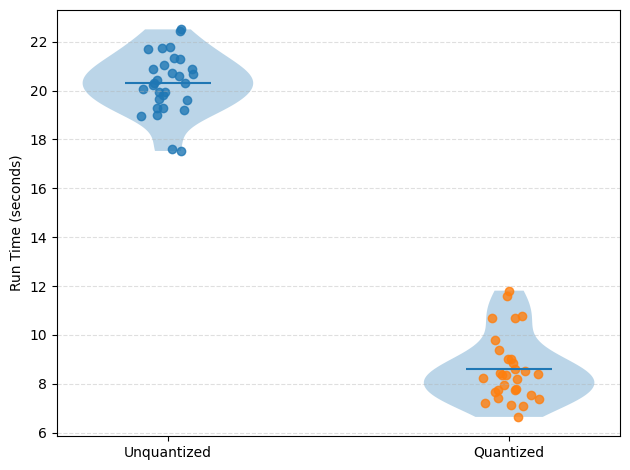

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

u = time_record["unquantized"]
q = time_record["quantized"]

fig, ax = plt.subplots()

ax.violinplot([u, q], showmeans=True, showextrema=False)

x1 = np.random.normal(1, 0.04, size=len(u))
x2 = np.random.normal(2, 0.04, size=len(q))

ax.scatter(x1, u, alpha=0.8)
ax.scatter(x2, q, alpha=0.8)
ax.grid(axis="y", linestyle="--", alpha=0.4)

ax.set_xticks([1, 2])
ax.set_xticklabels(["Unquantized", "Quantized"])
ax.set_ylabel("Run Time (seconds)")

fig.tight_layout()